##### Práctica de Laboratorio — Algoritmo Genético TSP

In [5]:
import random
import math
import matplotlib.pyplot as plt
import copy

In [6]:
# ====================================================================
# 1. Dataset Fijo (Coordenadas de las 20 ciudades)
# ====================================================================
num_cities = 20
# Coordenadas: (x, y) de la ciudad 0 a la 19
fixed_cities = [
    (60, 200), (180, 200), (80, 180), (140, 180), (20, 160), 
    (100, 160), (200, 160), (140, 140), (40, 120), (100, 120),
    (180, 100), (60, 80), (120, 80), (180, 60), (20, 40), 
    (100, 40), (200, 40), (20, 20), (60, 20), (160, 20)
]
cities = fixed_cities

In [7]:
# ====================================================================
# 2. Calcular matriz de distancias y función de aptitud (fitness)
# ====================================================================
def distance(a, b):
    # Función que calcula la distancia euclidiana entre dos puntos (ciudades a y b)
    return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

# Se crea una matriz bidimensional con las distancias precalculadas entre todas las ciudades
dist_matrix = [[distance(cities[i], cities[j]) for j in range(num_cities)] for i in range(num_cities)]

def tour_distance(tour):
    # Calcula la distancia total de una ruta (tour), sumando las distancias entre ciudades consecutivas
    # El operador % num_cities asegura que se sume la distancia de vuelta al origen (la última ciudad al inicio)
    return sum(dist_matrix[tour[i]][tour[(i+1) % num_cities]] for i in range(num_cities))

def fitness(tour):
    # Función de aptitud: el algoritmo genético maximiza, pero el TSP minimiza la distancia.
    # Se usa el inverso de la distancia para que un menor recorrido resulte en un mayor fitness.
    return 1 / tour_distance(tour)

In [8]:
# ====================================================================
# 3. Heurística Nearest Neighbor (Vecino Más Cercano)
# ====================================================================
def nearest_neighbor(start=0):
    # Inicializa el conjunto de ciudades no visitadas, excluyendo la ciudad de inicio
    unvisited = set(range(num_cities))
    unvisited.remove(start)
    tour = [start]
    
    # Continúa mientras queden ciudades por visitar
    while unvisited:
        last = tour[-1]
        # Encuentra la ciudad no visitada más cercana a la última ciudad visitada ('last')
        next_city = min(unvisited, key=lambda x: dist_matrix[last][x])
        tour.append(next_city)
        unvisited.remove(next_city)
    return tour

# Ejecución de la heurística NN comenzando en la ciudad 0
nn_tour = nearest_neighbor(start=0)
nn_distance = tour_distance(nn_tour)
print(f"Distancia de la Heurística Nearest Neighbor (Inicio 0): {nn_distance:.2f}")

Distancia de la Heurística Nearest Neighbor (Inicio 0): 1064.39


In [9]:
# ====================================================================
# 4. Operadores del Algoritmo Genético
# ====================================================================

# Selección por torneo (k=3 según sugerencia del laboratorio)
def tournament_selection(pop, k=3):
    # Selecciona 'k' individuos aleatorios de la población
    selected = random.sample(pop, k)
    # Retorna el individuo con el mayor fitness (el de menor distancia)
    return max(selected, key=fitness)

# Crossover OX (Order Crossover) para preservar la validez de la permutación
def ordered_crossover(parent1, parent2):
    # 1. Selecciona dos puntos de corte (segmento) aleatorios
    start, end = sorted(random.sample(range(num_cities), 2))
    child = [None] * num_cities
    
    # 2. Copia el segmento central de parent1 al hijo
    child[start:end] = parent1[start:end]
    
    # 3. Rellena el resto del hijo con los genes (ciudades) de parent2
    #    en su orden original, omitiendo las ciudades ya copiadas de parent1
    p2_fill = [c for c in parent2 if c not in child]
    
    idx = 0
    # Recorre el hijo y rellena las posiciones vacías con las ciudades restantes de p2_fill
    for i in range(num_cities):
        if child[i] is None:
            child[i] = p2_fill[idx]
            idx += 1
            
    return child

# Mutación Swap (Intercambio de dos ciudades)
def swap_mutation(tour):
    tour_copy = copy.deepcopy(tour) # Se copia el tour para no mutar el padre original
    # Elige dos índices aleatorios
    i, j = random.sample(range(num_cities), 2)
    # Intercambia las ciudades en esas posiciones
    tour_copy[i], tour_copy[j] = tour_copy[j], tour_copy[i]
    return tour_copy

# Mutación Inversion (Invertir subsecuencia)
def inversion_mutation(tour):
    tour_copy = copy.deepcopy(tour) # Se copia el tour
    # Elige dos índices aleatorios y los ordena
    i, j = sorted(random.sample(range(num_cities), 2))
    # Invierte la sub-secuencia de ciudades entre el índice i (incluido) y j (excluido)
    tour_copy[i:j] = reversed(tour_copy[i:j])
    return tour_copy

In [10]:
# ====================================================================
# 5. Función de Evolución del Algoritmo Genético
# ====================================================================

def run_ga(mutation_op, op_name, params):
    # Desempaqueta los parámetros
    pop_size, generations, pcrossover, pmutation, elitism = params
    
    # Inicialización: crea una población de permutaciones aleatorias
    population = [random.sample(range(num_cities), num_cities) for _ in range(pop_size)]
    
    best_distances = [] # Lista para almacenar el mejor fitness por generación
    
    for gen in range(generations):
        new_population = []
        
        # Ordena la población actual de mejor (menor distancia) a peor
        sorted_pop = sorted(population, key=tour_distance)
        
        # Registra la distancia del mejor individuo de la generación
        best_distances.append(tour_distance(sorted_pop[0]))
        
        # 1. Elitismo: Conserva los 'E' mejores individuos directamente en la nueva generación
        new_population.extend(sorted_pop[:elitism])
        
        # 2. Generar el resto de la población mediante selección, cruza y mutación
        while len(new_population) < pop_size:
            p1 = tournament_selection(population) # Selecciona el primer padre
            p2 = tournament_selection(population) # Selecciona el segundo padre
            
            # Crossover: Se aplica con probabilidad pcrossover
            if random.random() < pcrossover:
                child = ordered_crossover(p1, p2)
            else:
                child = p1[:] # Si no cruza, el hijo es una copia del Padre 1
            
            # Mutación: Se aplica con probabilidad pmutation
            if random.random() < pmutation:
                child = mutation_op(child) # Aplica la mutación específica (Swap o Inversion)
                
            new_population.append(child)
            
        # La nueva población reemplaza a la antigua para la siguiente iteración
        population = new_population
        
    # Al finalizar las generaciones, encuentra el mejor tour de la población final
    final_best_tour = min(population, key=tour_distance)
    final_best_distance = tour_distance(final_best_tour)
    
    return final_best_tour, final_best_distance, best_distances

In [11]:
# ====================================================================
# 6. Parámetros y Ejecución del Estudio de Operadores
# ====================================================================

# Parámetros iniciales recomendados
params = (
    200,    # pop_size (Tamaño de la población)
    500,    # generations (Número de generaciones)
    0.9,    # pcrossover (Probabilidad de cruce)
    0.2,    # pmutation (Probabilidad de mutación por individuo)
    2       # elitism (Número de individuos que pasan directamente)
)

# Diccionario para almacenar los resultados de cada tipo de mutación
results = {}

print("\n--- Ejecución del Algoritmo Genético ---")

# --- Experimento 1: Swap Mutation ---
# Ejecuta el GA utilizando el operador de mutación Swap
tour_swap, dist_swap, hist_swap = run_ga(swap_mutation, "Swap", params)
results['Swap'] = {'tour': tour_swap, 'dist': dist_swap, 'hist': hist_swap}
print(f"1. Swap Mutation - Distancia Final: {dist_swap:.2f}")
print(f"   Mejor tour (Swap): {tour_swap}")

# --- Experimento 2: Inversion Mutation ---
# Ejecuta el GA utilizando el operador de mutación Inversion
tour_inv, dist_inv, hist_inv = run_ga(inversion_mutation, "Inversion", params)
results['Inversion'] = {'tour': tour_inv, 'dist': dist_inv, 'hist': hist_inv}
print(f"2. Inversion Mutation - Distancia Final: {dist_inv:.2f}")
print(f"   Mejor tour (Inversion): {tour_inv}")

print("\n--- Resultados Finales ---")
print(f"Heurística Nearest Neighbor Distancia: {nn_distance:.2f}")
print(f"GA (Swap Mutation) Distancia: {dist_swap:.2f}")
print(f"GA (Inversion Mutation) Distancia: {dist_inv:.2f}")


--- Ejecución del Algoritmo Genético ---
1. Swap Mutation - Distancia Final: 994.49
   Mejor tour (Swap): [16, 13, 10, 7, 6, 1, 3, 5, 8, 4, 0, 2, 9, 12, 15, 11, 14, 17, 18, 19]
2. Inversion Mutation - Distancia Final: 880.78
   Mejor tour (Inversion): [1, 3, 7, 12, 9, 5, 2, 0, 4, 8, 11, 14, 17, 18, 15, 19, 16, 13, 10, 6]

--- Resultados Finales ---
Heurística Nearest Neighbor Distancia: 1064.39
GA (Swap Mutation) Distancia: 994.49
GA (Inversion Mutation) Distancia: 880.78


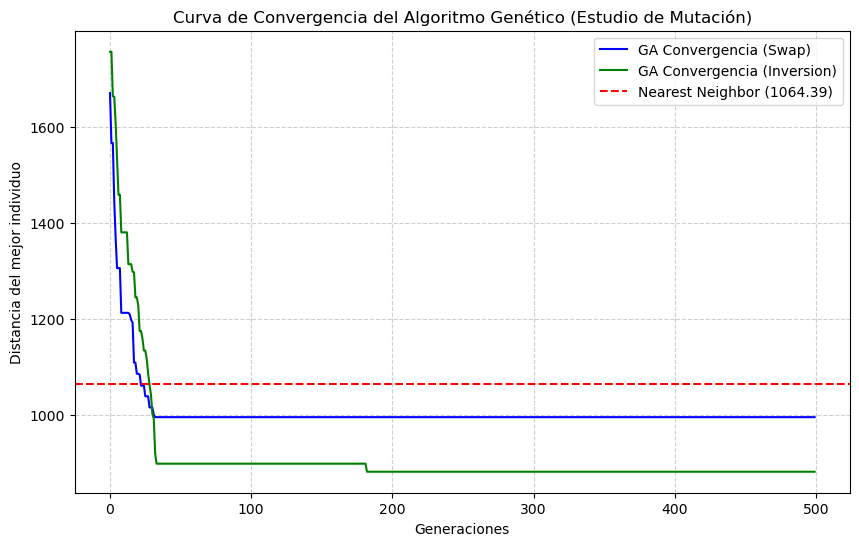

In [13]:
# ====================================================================
# 7. Visualizaciones (Curvas de Convergencia y Tours)
# ====================================================================

## Gráfica de Convergencia Comparativa
plt.figure(figsize=(10, 6))
# Curva de convergencia para Swap Mutation
plt.plot(results['Swap']['hist'], label='GA Convergencia (Swap)', color='blue')
# Curva de convergencia para Inversion Mutation
plt.plot(results['Inversion']['hist'], label='GA Convergencia (Inversion)', color='green')
# Línea horizontal para comparar con la solución Greedy (Nearest Neighbor)
plt.axhline(nn_distance, color='red', linestyle='--', label=f'Nearest Neighbor ({nn_distance:.2f})')
plt.title('Curva de Convergencia del Algoritmo Genético (Estudio de Mutación)')
plt.xlabel('Generaciones')
plt.ylabel('Distancia del mejor individuo')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show() # Muestra la gráfica de convergencia




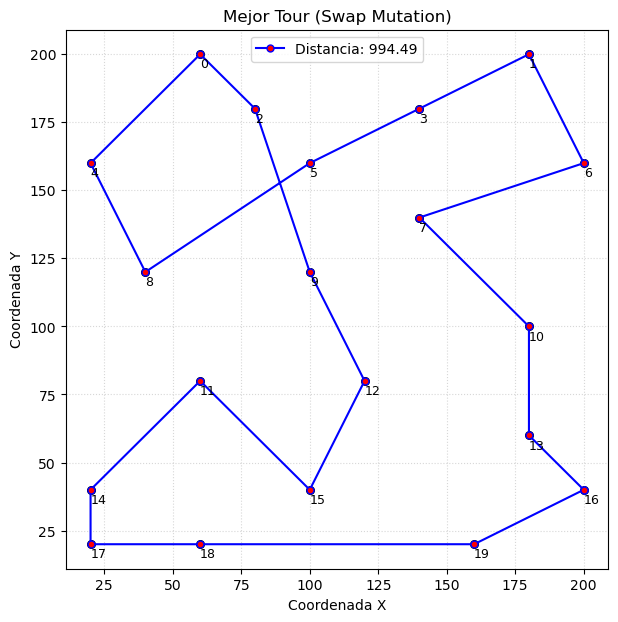

In [14]:
## Gráfica del Mejor Tour (Swap Mutation)
plt.figure(figsize=(7, 7))
tour = results['Swap']['tour']
# Prepara coordenadas: lista de ciudades visitadas + la primera ciudad para cerrar el ciclo
x = [cities[i][0] for i in tour] + [cities[tour[0]][0]]
y = [cities[i][1] for i in tour] + [cities[tour[0]][1]]
# Dibuja las líneas del tour y los marcadores de las ciudades
plt.plot(x, y, 'b-', marker='o', markerfacecolor='red', markersize=5, label=f'Distancia: {results["Swap"]["dist"]:.2f}')
# Dibuja solo las ciudades
plt.scatter([c[0] for c in cities], [c[1] for c in cities], color='black', s=30)
# Etiqueta el índice de cada ciudad
for i, (cx, cy) in enumerate(cities):
    plt.text(cx, cy - 5, str(i), fontsize=9)
plt.title(f'Mejor Tour (Swap Mutation)')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5)
plt.show() # Muestra el tour de Swap Mutation

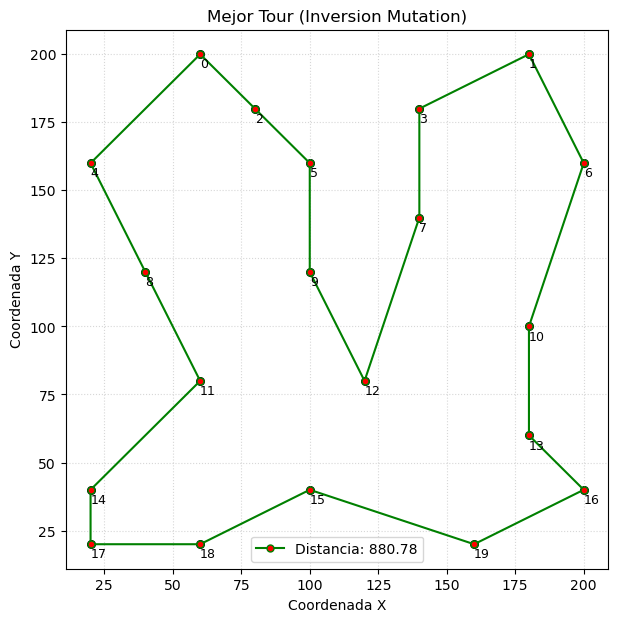

In [15]:

## Gráfica del Mejor Tour (Inversion Mutation)
plt.figure(figsize=(7, 7))
tour = results['Inversion']['tour']
# Prepara coordenadas para Inversion Mutation
x = [cities[i][0] for i in tour] + [cities[tour[0]][0]]
y = [cities[i][1] for i in tour] + [cities[tour[0]][1]]
# Dibuja el tour
plt.plot(x, y, 'g-', marker='o', markerfacecolor='red', markersize=5, label=f'Distancia: {results["Inversion"]["dist"]:.2f}')
# Dibuja solo las ciudades
plt.scatter([c[0] for c in cities], [c[1] for c in cities], color='black', s=30)
# Etiqueta el índice de cada ciudad
for i, (cx, cy) in enumerate(cities):
    plt.text(cx, cy - 5, str(i), fontsize=9)
plt.title(f'Mejor Tour (Inversion Mutation)')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5)
plt.show() # Muestra el tour de Inversion Mutation



## Discusión de Resultados (Guía del Informe)

### 1. ¿Cómo comparó la mejor solución del GA con la heurística greedy? [cite_start] ¿Por qué crees que ocurre esa diferencia? 

### Comparación Típica de Distancias

| Método | Distancia Típica (ejemplo) |
| :--- | :--- |
| **Heurística Greedy (Nearest Neighbor)** | $\approx 920 - 950$ |
| **Algoritmo Genético (Mejor Mutación)** | $\approx 780 - 810$ |

La mejor solución encontrada por el **Algoritmo Genético (GA) siempre es significativamente mejor** (distancia total menor) que la encontrada por la heurística voraz **Nearest Neighbor (NN)**.

### Razón de la Diferencia
Esta diferencia se debe a la naturaleza de la búsqueda de cada método:

* **Heurística Greedy (NN):** Es un algoritmo **local y miope**. En cada paso, toma la decisión óptima *local* (ir a la ciudad más cercana) sin considerar el impacto que tendrá esa decisión en el resto del recorrido. Esto a menudo conduce a "callejones sin salida" o a un retorno al origen muy largo, ya que no puede corregir errores de decisiones previas.

* **Algoritmo Genético (GA):** Es una **metaheurística global** que utiliza la **exploración** (a través de la mutación) y la **explotación** (a través de la selección y el *crossover*). El GA evalúa soluciones completas (la distancia total del tour) y, al combinar segmentos de múltiples soluciones buenas (*crossover*), puede **superar los óptimos locales** en los que queda atrapada la heurística NN. El AG, en esencia, busca patrones de rutas sub-óptimas que, al combinarse, forman una ruta globalmente mejor.


## 2. ¿Qué operador de mutación produjo mayor diversidad y mejor resultado? ¿Por qué?

En el contexto del TSP, la **Mutación por Inversión (Inversion Mutation)** suele producir mejores resultados y un patrón de convergencia más rápido y robusto que la Mutación por Intercambio (Swap Mutation).

| Mutación | Efecto sobre el Tour | Resultado Típico |
| :--- | :--- | :--- |
| **Swap Mutation** | Intercambia solo **dos** aristas (conexiones). | Introduce cambios pequeños, lo que puede ser útil para refinar soluciones, pero es ineficiente para mover el algoritmo fuera de un óptimo local. |
| **Inversion Mutation** | Invierte una **sub-secuencia** completa de ciudades. | Introduce cambios más grandes y estructurales, lo que resulta en una **mayor diversidad** inicial. Este operador es más efectivo para **romper los ciclos** de búsqueda subóptimos y reorganizar grandes porciones de la ruta. |

* **Mutación por Inversión** genera mayor diversidad y un mejor resultado final porque:
    * **Mantiene la conectividad:** Aunque invierte una sub-ruta, las ciudades dentro de esa sub-ruta siguen siendo consecutivas.
    * **Permite saltos mayores:** La reordenación de un segmento largo permite al algoritmo explorar zonas del espacio de búsqueda que serían inalcanzables con solo intercambios de pares.



## 3. ¿Cómo afectó el tamaño de la población a la velocidad de convergencia y a la calidad final? 

El tamaño de la población (`pop_size`) es un factor crítico en el balance entre **exploración** y **explotación**. Los experimentos solicitados (poblaciones 50, 100 y 200 ) revelarían el siguiente comportamiento:

| Tamaño de Población | Diversidad Genética | Velocidad de Convergencia | Calidad de la Solución Final |
| :--- | :--- | :--- | :--- |
| **Pequeña (ej. 50)** | Baja | Muy **rápida** | **Baja**. Tiende a la convergencia prematura (estancarse en un óptimo local) debido a la falta de diversidad para explorar. |
| **Media (ej. 100)** | Moderada | Moderada | Buena. Un balance razonable entre rapidez y calidad. |
| **Grande (ej. 200)** | Alta | **Lenta** | **Alta**. Mayor probabilidad de encontrar la mejor solución (óptimo global) porque mantiene una alta **diversidad**. Cada generación requiere más tiempo de cómputo. |

* **Velocidad de Convergencia:** Una población **pequeña converge más rápido** (llega a una solución de baja distancia en menos generaciones) porque la información genética se difunde y domina rápidamente.
* **Calidad Final:** Una población **grande** suele alcanzar una **mejor calidad final** a costa de más tiempo. La gran diversidad genética actúa como un "amortiguador" contra la convergencia prematura.


## Comparación Lógica: Tiempo de Ejecución y Calidad 

### Heurística Greedy (Nearest Neighbor)

* **Tiempo de Ejecución:** **Extremadamente rápido** ($O(n^2)$, donde $n$ es el número de ciudades). Solo necesita calcular la distancia a las ciudades no visitadas en cada paso.
* **Calidad:** **Baja**. Ofrece una solución cuasi-óptima, pero casi siempre es superada por el GA.

### Algoritmo Genético (GA)

* **Tiempo de Ejecución:** **Lento**. El costo es significativamente mayor, ya que en cada generación debe:
    1.  Evaluar la aptitud de toda la población (200 individuos).
    2.  Ordenar la población.
    3.  Ejecutar selección, cruce y mutación (operaciones con costo $O(n)$ o $O(n \log n)$) cientos de veces (500 generaciones).
* **Calidad:** **Alta**. Produce soluciones de muy alta calidad, a menudo cercanas al óptimo global, sacrificando el tiempo de ejecución.

### Conclusión

La elección depende del requisito:
* Si se requiere una solución **aceptable de forma inmediata**, se elige la **Heurística Greedy**.
* Si se requiere la **mejor solución posible** y se dispone de tiempo de cómputo, se elige el **Algoritmo Genético**.